In [1]:
# encoding: utf8
"""
A very simple example of using STDP.

A single postsynaptic neuron fires at a constant rate. We connect several
presynaptic neurons to it, each of which fires spikes with a fixed time
lag or time advance with respect to the postsynaptic neuron.
The weights of these connections are very small, so they will not|
significantly affect the firing times of the post-synaptic neuron.
We plot the amount of potentiation or depression of each synapse as a
function of the time difference.

"""
# Coder: Janilbols Wong
# Edit from example simple_STDP.py

from __future__ import division
from math import exp
import numpy
import neo
from quantities import ms
from pyNN.utility import get_simulator, init_logging, normalized_filename
from pyNN.utility.plotting import DataTable
from pyNN.parameters import Sequence
from importlib import import_module

## === simulator para & options ===


In [2]:
op_simulator = "neuron"
op_debug = False
op_dendritic_delay_fraction = False
op_fit_curve = False
op_plot_figure = True

## === Parameters ===

In [3]:
firing_period = 100.0    # (ms) interval between spikes
cell_parameters = {
    "tau_m": 10.0,       # (ms)
    "v_thresh": -50.0,   # (mV)
    "v_reset": -60.0,    # (mV)
    "v_rest": -60.0,     # (mV)
    "cm": 1.0,           # (nF)
    "tau_refrac": firing_period / 2,  # (ms) long refractory period to prevent bursting
}
n = 60                  # number of synapses / number of presynaptic neurons
delta_t = 1.0            # (ms) time difference between the firing times of neighbouring neurons
t_stop = 10 * firing_period + n * delta_t
delay = 0.01              # (ms) synaptic time delay, default=3.0

## === Configure the simulator ===

In [4]:
sim = import_module("pyNN."+op_simulator)

if op_debug: 
    init_logging(None, debug=True)

sim.setup(timestep=0.01, min_delay=delay, max_delay=delay)

0

## === Build the network ===

In [5]:
def build_spike_sequences(period, duration, n, delta_t):
    """
    Return a spike time generator for `n` neurons (spike sources), where
    all neurons fire with the same period, but neighbouring neurons have a relative
    firing time difference of `delta_t`.
    """
    def spike_time_gen(i):
        """Spike time generator. `i` should be an array of indices."""
        return [Sequence(numpy.arange(period + j * delta_t, duration, period)) for j in (i - n // 2)]
    return spike_time_gen

spike_sequence_generator = build_spike_sequences(firing_period, t_stop, n, delta_t)
# presynaptic population
p_in = sim.Population(n, sim.SpikeSourceArray(spike_times=spike_sequence_generator),
                    label="presynaptic")
# single postsynaptic neuron
p_mid_1 = sim.Population(60, sim.IF_cond_exp(**cell_parameters),
                    initial_values={"v": cell_parameters["v_reset"]}, label="postsynaptic_1")
p_mid_2 = sim.Population(1, sim.IF_cond_exp(**cell_parameters),
                    initial_values={"v": cell_parameters["v_reset"]}, label="postsynaptic_2")
# drive to the postsynaptic neuron, ensuring it fires at exact multiples of the firing period
p_out = sim.Population(1, sim.SpikeSourceArray(spike_times=numpy.arange(firing_period - delay, t_stop, firing_period)),
                    label="driver")

# we set the initial weights to be very small, to avoid perturbing the firing times of the
# postsynaptic neurons
stdp_model = sim.STDPMechanism(
                timing_dependence=sim.SpikePairRule(tau_plus=20.0, tau_minus=20.0,
                                                    A_plus=0.01, A_minus=0.012),
                weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=0.0000001),
                weight=0.00000005,
                delay=delay,
                dendritic_delay_fraction=float(op_dendritic_delay_fraction))
connections_1 = sim.Projection(p_in, p_mid_1, sim.OneToOneConnector(), 
                               sim.StaticSynapse(weight=10.0, delay=delay))
connections_2 = sim.Projection(p_mid_1, p_mid_2, sim.AllToAllConnector(), stdp_model)

# the connection weight from the driver neuron is very strong, to ensure the
# postsynaptic neuron fires at the correct times

driver_connection = sim.Projection(p_out, p_mid_2, sim.OneToOneConnector(), # sim.AllToAllConnector(),#
                                   sim.StaticSynapse(weight=10.0, delay=delay))


## == Instrument the network ===

In [6]:
p_in.record('spikes')
p_mid_1.record(['spikes', 'v'])
p_mid_2.record(['spikes', 'v'])


class WeightRecorder(object):
    """
    Recording of weights is not yet built in to PyNN, so therefore we need
    to construct a callback object, which reads the current weights from
    the projection at regular intervals.
    """

    def __init__(self, sampling_interval, projection):
        self.interval = sampling_interval
        self.projection = projection
        self._weights = []

    def __call__(self, t):
        self._weights.append(self.projection.get('weight', format='list', with_address=False))
        return t + self.interval

    def get_weights(self):
        signal = neo.AnalogSignal(self._weights, units='nA', sampling_period=self.interval * ms,
                                  name="weight")
        signal.channel_index = neo.ChannelIndex(numpy.arange(len(self._weights[0])))
        return signal

weight_recorder_1 = WeightRecorder(sampling_interval=1.0, projection=connections_1)
weight_recorder_2 = WeightRecorder(sampling_interval=1.0, projection=connections_2)


## === Run the simulation ===

In [7]:
sim.run(t_stop, callbacks=[weight_recorder_1,weight_recorder_2]) #

1059.999999999927

In [8]:
# === Save the results =============================

filename = normalized_filename("Results", "hello_stdp", "pkl", op_simulator)
p_mid_2.write_data(filename, annotations={'script_name': "Janilbols - PyNN - Test"})

presynaptic_data = p_in.get_data().segments[0]
postsynaptic_data_1 = p_mid_1.get_data().segments[0]
postsynaptic_data_2 = p_mid_2.get_data().segments[0]

print("Post-synaptic 1 spike times: %s" % postsynaptic_data_1.spiketrains[0])
print("Post-synaptic 2 spike times: %s" % postsynaptic_data_2.spiketrains[0])

weights_1 = weight_recorder_1.get_weights()
weights_2 = weight_recorder_2.get_weights()
final_weights_1 = numpy.array(weights_1[-1])
final_weights_2 = numpy.array(weights_2[-1])
deltas_1 = delta_t * numpy.arange(n // 2, -n // 2, -1)
print("Final weights - 1: %s\n\n" % final_weights_1)
deltas_2 = delta_t * numpy.arange(n // 2, -n // 2, -1)
print("Final weights - 2: %s\n\n" % final_weights_2)
plasticity_data_1 = DataTable(deltas_1, final_weights_1)
plasticity_data_2 = DataTable(deltas_2, final_weights_2)

Post-synaptic 1 spike times: [ 70.03 170.03 270.03 370.03 470.03 570.03 670.03 770.03 870.03 970.03] ms
Post-synaptic 2 spike times: [ 100.02  200.02  300.02  400.02  500.02  600.02  700.02  800.02  900.02
 1000.02] ms
Final weights - 1: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10.]


Final weights - 2: [5.16945229e-08 5.18141934e-08 5.19384004e-08 5.20674545e-08
 5.22016782e-08 5.23414072e-08 5.24869911e-08 5.26387936e-08
 5.27971946e-08 5.29625900e-08 5.31353933e-08 5.33160369e-08
 5.35049722e-08 5.37026718e-08 5.39096300e-08 5.41263643e-08
 5.43534167e-08 5.45913548e-08 5.48407738e-08 5.51022972e-08
 5.53765790e-08 5.56643051e-08 5.59661949e-08 5.62830032e-08
 5.66155224e-08 5.69645838e-08 5.73310603e-08 5.77158682e-08
 5.81199699e-08 5.85443757e-08 3.79999268e-08 3.85912866e-08
 3.91541

In [9]:
## === optionally plot a figure ===

Results/20181119/hello_stdp_neuron_20181119-151806.png


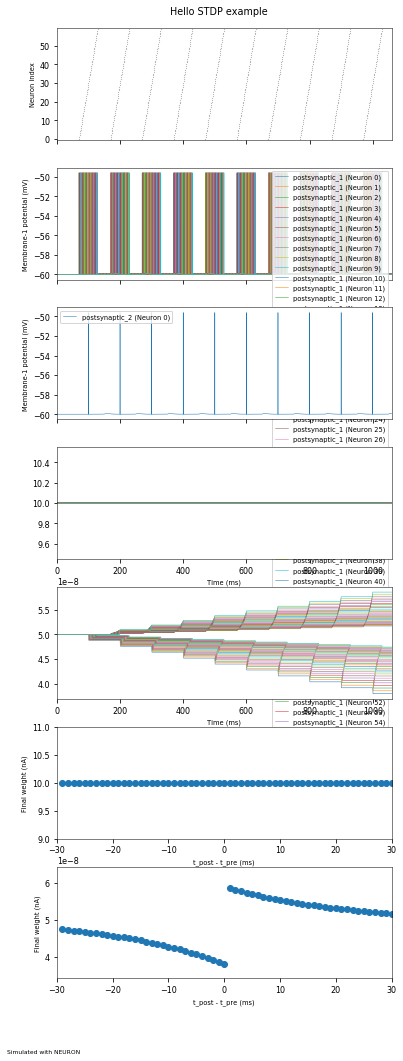

In [10]:

if op_fit_curve:
    def double_exponential(t, t0, w0, wp, wn, tau):
        return w0 + numpy.where(t >= t0, wp * numpy.exp(-(t - t0) / tau), wn * numpy.exp((t - t0) / tau))
    p0 = (-1.0, 5e-8, 1e-8, -1.2e-8, 20.0)
    popt, pcov = plasticity_data.fit_curve(double_exponential, p0, ftol=1e-10)
    print("Best fit parameters: t0={0}, w0={1}, wp={2}, wn={3}, tau={4}".format(*popt))


if op_plot_figure:
    from pyNN.utility.plotting import Figure, Panel, DataTable
    figure_filename = filename.replace("pkl", "png")
    Figure(
        # raster plot of the presynaptic neuron spike times
        Panel(presynaptic_data.spiketrains,
              yticks=True, markersize=0.2, xlim=(0, t_stop)),
        # membrane potential of the postsynaptic neuron 1
        Panel(postsynaptic_data_1.filter(name='v')[0],
              ylabel="Membrane-1 potential (mV)",
              data_labels=[p_mid_1.label], yticks=True, xlim=(0, t_stop)),
        # membrane potential of the postsynaptic neuron 1
        Panel(postsynaptic_data_2.filter(name='v')[0],
              ylabel="Membrane-1 potential (mV)",
              data_labels=[p_mid_2.label], yticks=True, xlim=(0, t_stop)),
        # evolution of the synaptic weights with time
        Panel(weights_1, xticks=True, yticks=True, xlabel="Time (ms)",
              legend=False, xlim=(0, t_stop)),
        # evolution of the synaptic weights with time
        Panel(weights_2, xticks=True, yticks=True, xlabel="Time (ms)",
              legend=False, xlim=(0, t_stop)),
        # scatterplot of the final weight of each synapse against the relative
        # timing of pre- and postsynaptic spikes for that synapse
        Panel(plasticity_data_1,  
              xticks=True, yticks=True, xlim=(-n / 2 * delta_t, n / 2 * delta_t),
              ylim=(0.9 * final_weights_1.min(), 1.1 * final_weights_1.max()),
              xlabel="t_post - t_pre (ms)", ylabel="Final weight (nA)",
              show_fit=op_fit_curve),
        Panel(plasticity_data_2,  
              xticks=True, yticks=True, xlim=(-n / 2 * delta_t, n / 2 * delta_t),
              ylim=(0.9 * final_weights_2.min(), 1.1 * final_weights_2.max()),
              xlabel="t_post - t_pre (ms)", ylabel="Final weight (nA)",
              show_fit=op_fit_curve),
        title="Hello STDP example",
        annotations="Simulated with %s" % op_simulator.upper()
    ).save(figure_filename)
    print(figure_filename)


In [12]:
# === Clean up and quit ========================================================
sim.end()